
# Sentiment - Analyser #

The "score" attribute we stored in every comment entry inside our database is already
a ruff estimation of the sentiment of a comment.<br>
However, this score can currently be any number which can vary substantially depending on the number
of likes a comment received... <br>
Besides that there is also the observation that a high like to dislike ratio on
youtube videos is the defacto standard, this is because human being mostly tend
to like positivity. :) <br>
Therefore we need to to the two following things in order to get a "true" sentiment: <br>

- normalize so that the sentiment is between 0 and 1 (for all comments of a video)

- shift the score a little so that a sentiment of 0.7 is more like 0.5

In [414]:
def sentiment_from_score(video_likes, video_dislikes, min_score, max_score, score):
        ratio = float(video_likes)/(float(video_likes)+float(video_dislikes))
        score, min_score, max_score = float(score), float(min_score), float(max_score)
        scaler = max_score - min_score
        if scaler == 0.0 : scaler = 1
        normalized_score = (( score - min_score ) / scaler) / 2
        assert normalized_score <= 0.5 and normalized_score >= 0.0
        capper = min(1, ratio/0.75)**2 
        normalized_score =  capper * 0.5 + normalized_score
        assert normalized_score <= 1 and normalized_score >= 0.0 
        return normalized_score

Besides calculating a sentiment value between 0 and 1 we also need to make
the comment texts we scraped more digestable for the computer... <br>
The following method does just that by replacing emojis with proper words and
also removes duplicate punctuations.

In [415]:
def text_cleaner_and_splitter(text):
    return (text.lower()
            .replace('❤️', ' heart ').replace('💯', ' 100 ').replace('❤', ' heart ')
            .replace('🙏', ' pray ').replace('😘', ' kiss ').replace('🤗', ' happy ')
            .replace('💥', ' boom ').replace('✔️', ' like ').replace('😍', ' love ')
            .replace('🐱', ' cat ').replace('💔', ' broken heart ').replace('😵', ' confused ') 
            .replace('😄', ' awesome ').replace('👍', ' thumbs up ').replace('😎', ' cool ')
            .replace('🐷', ' pig ').replace('🤘', " rock'n roll ").replace('🤣', ' laughing hard ')
            .replace('😩', ' oh no ').replace('💎', ' diamond ').replace('😊', ' nice ')
            .replace('☺️', ' very nice ').replace('🙃', ' upside down smile ').replace('🤔', ' not sure ')
            .replace('😂', ' laughing ').replace('🙋🏻‍♀️',' hi ').replace('🥰', ' lovely ').replace('🥺',' sad ')
            .replace('!!!!', '!').replace('!!!', '!').replace('!!', '!')
            .replace('????', '?').replace('???', '?').replace('??', '?')
            .replace('oooo','o').replace('oooo','o').replace('ooo','o')
            .replace('..','...').replace('......','...').replace('....','...').replace('....','...').replace('...',' ... ')
            .replace('    ', ' ').replace('   ', ' ').replace('  ', ' ')
            .split())

## Loading Data ##

Before starting with the machine learning and sentiment analysis
we first have to load the data and clean it! <br>
We store the data in the following 5 variables: <br>

- `video_max_comment_score` : A dictionary which ought to hold the largest score per video (of all comments). 

- `video_min_comment_score` : A dictionary which ought to hold the smallest score per video (of all comments).

- `comments` : A list of all comments (included the pre-pended video title).

- `sentiments` : A list of all sentiments calculated from the comment scores.

- `all_words` : A list of all words which will later be counted for further cleaning...

In [416]:

from neo4j import GraphDatabase

uri, user, password = 'bolt://localhost:7687', 'neo4j', 'neo4j_'

driver = GraphDatabase.driver(uri, auth=(user, password))
  
video_max_comment_score = dict()
video_min_comment_score = dict()
comments = []
sentiments = []
all_words = []

with driver.session() as session:
    def _q(query) : return session.run(query)
    #---------------------------------------

    result = _q("MATCH (n:Author)-[c:COMMENTED]->(v:Video) RETURN n, c, v") 
    records = []

    # We need to do some normalization!
    # So let's find the min/max scores for every video
    for record in result:
        if record['v']['title'] not in video_max_comment_score:
            video_max_comment_score[record['v']['title']] = float(record['c']['score'])
        elif float(video_max_comment_score[record['v']['title']]) > float(record['c']['score']):
            video_max_comment_score[record['v']['title']] = float(record['c']['score'])

        if record['v']['title'] not in video_min_comment_score:
            video_min_comment_score[record['v']['title']] = float(record['c']['score'])
        elif float(video_min_comment_score[record['v']['title']]) < float(record['c']['score']):
            video_min_comment_score[record['v']['title']] = float(record['c']['score'])
            
        if float(record['c']['likes']) > 0 :
            records.append(record)

    for record in records:
        normalized_score = sentiment_from_score(
            record['v']['likes'], 
            record['v']['dislikes'], 
            video_min_comment_score[record['v']['title']], 
            video_max_comment_score[record['v']['title']], 
            record['c']['score']
        )
        sentiments.append(normalized_score)
        
        newComment = text_cleaner_and_splitter(
            "%s | %s" % (record['v']['title'],record['c']['text'])
        )
        
        comments.append(newComment)
        all_words.extend(newComment)
        
        # For more difficult samples we also store comments without title! 
        # We take larger comments because they will most likely be useful!
        if len(record['c']['text']) > 32:
            comments.append( text_cleaner_and_splitter(record['c']['text']) )
            sentiments.append( normalized_score )
    
    #---------------------------------------
driver.close()
 
#from pprint import pprint
#pprint(comments)
    

In [417]:
print(comments[102])
print(sentiments[102])

['biden', 'warns', 'of', '‘devastating', 'consequences’', 'if', 'trump', 'delays', 'covid-19', 'relief', 'bill', '|', 'waste', 'of', 'money,', 'don’t', 'sign', 'any', 'sort', 'stimulus.']
0.725135976903643


In [418]:
print(comments[99])
print(sentiments[99])

['better', 'than', 'lose', 'their', 'freedom', 'they', 'still', 'have', 'to', 'chose', 'where', 'and', 'when', 'to', 'make', 'their', 'stand', 'against', 'their', 'enemies', 'in', 'government', 'no', 'need', 'to', 'sign', 'the', 'bill', '...']
0.6105526435703096


Let's see try to find the comment with the worst sentiment:

In [419]:
worst_i = -1
worst_score = 1
for i, score in enumerate( sentiments ):
    #print(i,score)
    if score < worst_score : 
        worst_score = score
        worst_i = i
        
print(comments[worst_i])
print(sentiments[worst_i])

['cuties', '|', 'official', 'trailer', '|', 'netflix', '|', '5', 'seconds', 'into', 'the', 'trailer', 'and', 'you', 'have', 'an', 'eleven', 'year', 'old', 'girl', 'dancing', 'in', 'tight', 'leather', 'pants.', 'i', 'mean', '...', "you're", 'aware', 'of', 'what', "you're", 'doing,', 'right?']
1.933805119513196e-05


## Clean the Comments with Spark ##

The comments are currently still full of redundancies and
many uncommon tokens / words.
In order to be able to filter the comments we use spark to count their occurrences. <br>
After that we can remove the uncommon ones...

In [420]:
from pyspark import SparkContext
 
sc = SparkContext("local", "First App") # We create a new spak context...
 
wordsRDD = sc.parallelize(all_words, 6) # And create a RDD for parallized execution...

# Now we count the words:
zipped = (wordsRDD
            .map(lambda word : (word,1))
            .reduceByKey( lambda a, b : a+b )
            .collect())
sc.stop() # Done! We can stop the context...              

# Let's convert this to a dictionary for faster access:
occurrences = {}
for word, count in zipped:
    occurrences[word] = count

print('Total number of unique words:', len(occurrences))

Total number of unique words: 32272


...and now let's remove rare tokens / words in order to cap the maximum amount of possible words a bit...

In [421]:
min_times = int(max(len(occurrences)/1500, 6))
print('One word should exist at least ',min_times,' times!')

def more_than_three(word):
    return occurrences[word] > min_times

for i, comment in enumerate(comments): 
    comments[i] = list(filter(more_than_three, comment))

One word should exist at least  21  times!


We also filter all comments which are under and over a certain size
in order to make training easier. <br>
Then we store the cleaned data into the following variables: <br>

- `clean_comments`

- `clean_sentiments`

In [422]:

def removed_short_comments(all_comments, all_sentiments):
    new_comments, new_sentiments = [], []
    
    for i, comment in enumerate(all_comments): 
        if len(comment) >= 8 and len(comment) <= 64 :
            new_comments.append(comment)
            new_sentiments.append(all_sentiments[i])
        
    return new_comments, new_sentiments

print('Number of comments before trimming:',len(comments))
print('Number of sentiments before trimming:',len(sentiments))

clean_comments, clean_sentiments = removed_short_comments(comments, sentiments)

print('Number of comments after trimming:',len(clean_comments))
print('Number of sentiments after trimming:',len(clean_sentiments))


Number of comments before trimming: 26673
Number of sentiments before trimming: 26673
Number of comments after trimming: 22257
Number of sentiments after trimming: 22257


In [423]:
print(clean_comments[:5])

[['biden', 'wants', 'new', 'coronavirus', 'relief', 'bill,', 'announces', 'diverse', 'economic', 'team', '|', 'women', 'matter', 'most', 'people', 'who', 'want', 'these', 'are', 'not', 'our', 'they', 'just', 'want', 'to', 'our', 'money'], ['women', 'matter', 'most', 'people', 'who', 'want', 'these', 'are', 'not', 'our', 'they', 'just', 'want', 'to', 'our', 'money'], ['biden', 'wants', 'new', 'coronavirus', 'relief', 'bill,', 'announces', 'diverse', 'economic', 'team', '|', 'gonna', 'be', 'the'], ['biden', 'wants', 'new', 'coronavirus', 'relief', 'bill,', 'announces', 'diverse', 'economic', 'team', '|', 'what', 'part', 'of', 'do', 'you', 'not', 'understand', 'news', 'biden', 'has', 'not', 'been'], ['what', 'part', 'of', 'do', 'you', 'not', 'understand', 'news', 'biden', 'has', 'not', 'been']]


---

# Sentiment Analysis with Pytorch #

Let's train a neural network on our data!

In [424]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == None : device = 'cpu'
# Assuming that we are on a CUDA machine, this should print a CUDA device: 
print(device)

cuda:0


## 1. Defining an LSTM Recurrent Neural Network Model ##

- `Xt` : Vectorized word at sentence index `t`

- `ht` : Output of lstm at sentence index `t`

![](images/lstm_illustration.webp)

In [425]:
# src/inspiration: https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
class LSTMScorePredictor(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim, actifun='softmax'):
        super(LSTMScorePredictor, self).__init__() 
        self.hidden_dim = hidden_dim
        self.actifun = actifun

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.to(device)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
            
        # The linear layer that maps from hidden state space to tag space
        self.lin = nn.Linear(hidden_dim, output_dim)

    def forward(self, sentence):  
        #print('sentence: ', sentence)
        embeds = self.word_embeddings(sentence) 
        #print(embeds.shape)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        out = self.lin(lstm_out.view(len(sentence), -1))
        if self.actifun == 'softmax' : out = F.log_softmax(out, dim=1)
        elif self.actifun == 'sigmoid' : out = torch.sigmoid(out) 
        
        return out

## 2. Word - Index encoding ##

PyTorch comes with a built in utility which encodes a given word index (from a total list of unique words)
into a fixed sized vector which represents that index (and thereby also the word).<br>
This utility is the one we already used inside the model, namely: `nn.Embedding(vocab_size, embedding_dim)`<br>

The `vocab_size` is the size of the total number of unique words and the `embedding_dim` is the size 
of the vectors which ought to encode a given index... <br>

So what we now need to do is a mapping between unique words and their unque indexes.<br>
The following class fulfills that role:

In [426]:

# Word to index encoding...
class Encoder:
    
    def __init__(self, training_data):
        self.word_to_ix = dict()
        # For each words-list (sentence) and tags-list in each tuple of training_data
        for sent, label in training_data:
            for word in sent:
                if word not in self.word_to_ix:  # word has not been assigned an index yet
                    self.word_to_ix[word] = len(self.word_to_ix)  # Assign each word with a unique index
        #print(self.word_to_ix)
        self.label_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

    def sequence_words(self, seq):
        idxs = [self.word_to_ix[w] for w in seq]
        return torch.tensor(idxs, dtype=torch.long)
    
    
    def sequence_labels(self, seq):
        idxs = [self.label_to_ix[w] for w in seq]
        return torch.tensor(idxs, dtype=torch.long)

## 3. Training Setup ##

Now we define a method which created and trains a LSTM-Model based on a set of passed configuration parameters...

In [427]:
import matplotlib.pyplot as plt
import random # for shuffling the training data

def exec_trial(
    training_data, 
    test_data=None,
    loss_function=None, 
    optimizer=None,
    epochs=300,
    do_label_encode=True,
    actifun='softmax', 
    embedding_dim=6, # These will usually be more like 32 or 64 dimensional.
    hidden_dim=6,# We will keep them small, so we can see how the weights change as we train.
    enc=None,
    step_every_sentence=True
):
    torch.manual_seed(42) 
    if enc == None: enc = Encoder(training_data)
        
    if not do_label_encode: output_dim = 1
    else: output_dim = len(enc.label_to_ix)
    
    model = LSTMScorePredictor(
        embedding_dim=embedding_dim, 
        hidden_dim=hidden_dim, 
        vocab_size=len(enc.word_to_ix), 
        output_dim=output_dim,
        actifun=actifun
    )
     
    model.to(device) # To GPU
    
    if loss_function == 'mse': loss_function = nn.MSELoss()
    elif loss_function == None: loss_function = nn.NLLLoss()
    
    if optimizer == 'adam': optimizer = optim.Adam(model.parameters(), lr=0.00001)
    elif optimizer == None: optimizer = optim.SGD(model.parameters(), lr=0.1)
  
    losses = []
    sentence_losses = []
    val_losses = []
    for epoch in range(epochs):  
        # The neural network should learn data more randomly:
        random.Random(666+epoch+999).shuffle(training_data) #... so we shuffle it! :)
        model.train()
        if not step_every_sentence: 
                model.zero_grad() 
        train_loss = 0
        for sentence, sentiments in training_data: 
            if step_every_sentence: 
                model.zero_grad() 
            sentence = enc.sequence_words(sentence)
            
            if do_label_encode: sentiments = enc.sequence_labels(sentiments) 
            sentiments = sentiments.to(device)
            sentence = sentence.to(device)       
                 
            loss = loss_function( model(sentence)  , sentiments)
            loss.backward()
            sentence_losses.append(loss.item())
            # summing train losses:
            train_loss = train_loss + loss.item() 
                
            if step_every_sentence: 
                optimizer.step()
        if not step_every_sentence:
            optimizer.step()
            
        losses.append( train_loss / len(training_data) ) # storing the average train loss!
        print('Epoch',epoch, 'loss =',train_loss / len(training_data))
        
        if test_data != None:
            model.eval() 
            sum_loss = 0
            for x_val, y_val in test_data: 
                sentence_in = enc.sequence_words(x_val).to(device)
                yhat = model(sentence_in)
                val_loss = loss_function(y_val.to(device), yhat)
                sum_loss += val_loss.item()
            val_losses.append( sum_loss / len(test_data) ) 
        
    print('Trial done! \n===========')  
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4)) 
    fig.suptitle('Horizontally stacked subplots')
    ax1.plot(losses, 'tab:green')
    if test_data != None:
        ax1.plot(val_losses)
    ax2.plot(sentence_losses, 'tab:blue')
    ax1.set_title('Epoch Losses')
    ax2.set_title('Word Losses') 
    
    return model

### 3.1 Unit-Testing the Model: ###

This is already a lot of code... <br>
Let's do some unit testing in order to make the defined logic more robust.

Epoch 0 loss = 1.1654255390167236
Epoch 1 loss = 1.1565314531326294
Epoch 2 loss = 1.1485129594802856
Epoch 3 loss = 1.141252040863037
Epoch 4 loss = 1.1346471309661865
Epoch 5 loss = 1.1286096572875977
Epoch 6 loss = 1.1230638027191162
Epoch 7 loss = 1.1179441213607788
Epoch 8 loss = 1.1131937503814697
Epoch 9 loss = 1.1087646484375
Epoch 10 loss = 1.104614496231079
Epoch 11 loss = 1.1007071733474731
Epoch 12 loss = 1.0970114469528198
Epoch 13 loss = 1.0935003757476807
Epoch 14 loss = 1.0901503562927246
Epoch 15 loss = 1.086941123008728
Epoch 16 loss = 1.0838547945022583
Epoch 17 loss = 1.0808758735656738
Epoch 18 loss = 1.0779906511306763
Epoch 19 loss = 1.0751869678497314
Epoch 20 loss = 1.0724540948867798
Epoch 21 loss = 1.0697824954986572
Epoch 22 loss = 1.0671638250350952
Epoch 23 loss = 1.0645900964736938
Epoch 24 loss = 1.0620546340942383
Epoch 25 loss = 1.0595508813858032
Epoch 26 loss = 1.0570732355117798
Epoch 27 loss = 1.0546163320541382
Epoch 28 loss = 1.0521754026412964
E

Epoch 241 loss = 0.08228951692581177
Epoch 242 loss = 0.08115757256746292
Epoch 243 loss = 0.08004961907863617
Epoch 244 loss = 0.07896509766578674
Epoch 245 loss = 0.07790343463420868
Epoch 246 loss = 0.07686430960893631
Epoch 247 loss = 0.07584691047668457
Epoch 248 loss = 0.07485100626945496
Epoch 249 loss = 0.07387589663267136
Epoch 250 loss = 0.07292120158672333
Epoch 251 loss = 0.07198633253574371
Epoch 252 loss = 0.07107095420360565
Epoch 253 loss = 0.0701744481921196
Epoch 254 loss = 0.06929648667573929
Epoch 255 loss = 0.06843657046556473
Epoch 256 loss = 0.06759428232908249
Epoch 257 loss = 0.06676913052797318
Epoch 258 loss = 0.0659608244895935
Epoch 259 loss = 0.06516876816749573
Epoch 260 loss = 0.06439270079135895
Epoch 261 loss = 0.06363218277692795
Epoch 262 loss = 0.06288686394691467
Epoch 263 loss = 0.06215636804699898
Epoch 264 loss = 0.061440277844667435
Epoch 265 loss = 0.060738302767276764
Epoch 266 loss = 0.060050059109926224
Epoch 267 loss = 0.059375178068876266

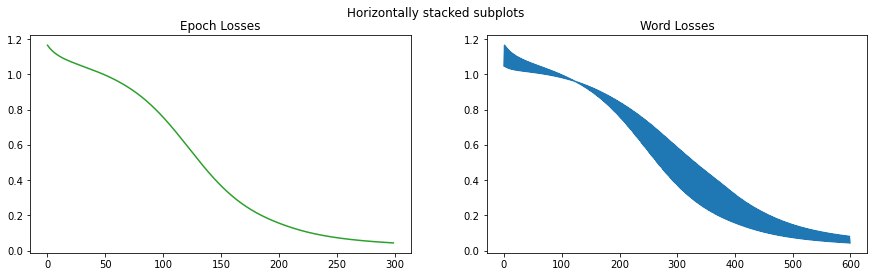

In [170]:
 
# Example training data:
training_data = [ 
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
enc = Encoder(training_data)

model = exec_trial(training_data, enc=enc)

# See what the scores are after training
with torch.no_grad():
    inputs = enc.sequence_words(training_data[0][0])
    tag_scores = model(inputs.to(device))

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(inputs)
    print(tag_scores)
    
assert str(inputs) == """tensor([0, 1, 2, 3, 4])"""
assert str(tag_scores.to('cpu')) == """tensor([[-0.0259, -4.5027, -4.2358],
        [-4.5316, -0.0617, -3.0154],
        [-2.6551, -2.9622, -0.1301],
        [-0.1583, -3.9917, -2.0562],
        [-4.2915, -0.0241, -4.5954]])"""


print('Unit test successful! :)')

C:\Users\Daglemino\Anaconda3\envs\dasi\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 4, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 loss = 0.26555222272872925
Epoch 1 loss = 0.26313287019729614
Epoch 2 loss = 0.2607865631580353
Epoch 3 loss = 0.2585119605064392
Epoch 4 loss = 0.25630760192871094
Epoch 5 loss = 0.2541719973087311
Epoch 6 loss = 0.2521035671234131
Epoch 7 loss = 0.250100702047348
Epoch 8 loss = 0.2481616884469986
Epoch 9 loss = 0.24628494679927826
Epoch 10 loss = 0.24446865916252136
Epoch 11 loss = 0.2427111566066742
Epoch 12 loss = 0.24101075530052185
Epoch 13 loss = 0.23936572670936584
Epoch 14 loss = 0.2377742975950241
Epoch 15 loss = 0.2362349033355713
Epoch 16 loss = 0.23474575579166412
Epoch 17 loss = 0.23330527544021606
Epoch 18 loss = 0.2319118082523346
Epoch 19 loss = 0.23056377470493317
Epoch 20 loss = 0.22925962507724762
Epoch 21 loss = 0.2279978096485138
Epoch 22 loss = 0.2267768681049347
Epoch 23 loss = 0.22559531033039093
Epoch 24 loss = 0.22445176541805267
Epoch 25 loss = 0.2233448624610901
Epoch 26 loss = 0.22227324545383453
Epoch 27 loss = 0.22123563289642334
Epoch 28 loss = 

Epoch 241 loss = 0.12338972091674805
Epoch 242 loss = 0.1226690411567688
Epoch 243 loss = 0.1219482570886612
Epoch 244 loss = 0.12122759222984314
Epoch 245 loss = 0.12050717324018478
Epoch 246 loss = 0.11978716403245926
Epoch 247 loss = 0.11906775087118149
Epoch 248 loss = 0.11834906041622162
Epoch 249 loss = 0.11763129383325577
Epoch 250 loss = 0.11691458523273468
Epoch 251 loss = 0.1161990538239479
Epoch 252 loss = 0.11548492312431335
Epoch 253 loss = 0.11477230489253998
Epoch 254 loss = 0.11406133323907852
Epoch 255 loss = 0.1133522018790245
Epoch 256 loss = 0.1126449927687645
Epoch 257 loss = 0.11193985491991043
Epoch 258 loss = 0.11123697459697723
Epoch 259 loss = 0.11053642630577087
Epoch 260 loss = 0.10983837395906448
Epoch 261 loss = 0.10914288461208344
Epoch 262 loss = 0.10845017433166504
Epoch 263 loss = 0.10776025056838989
Epoch 264 loss = 0.10707330703735352
Epoch 265 loss = 0.10638943314552307
Epoch 266 loss = 0.10570872575044632
Epoch 267 loss = 0.10503129661083221
Epoch 

Epoch 483 loss = 0.035023488104343414
Epoch 484 loss = 0.03489641100168228
Epoch 485 loss = 0.03477015346288681
Epoch 486 loss = 0.0346447117626667
Epoch 487 loss = 0.034520070999860764
Epoch 488 loss = 0.03439624607563019
Epoch 489 loss = 0.03427322208881378
Epoch 490 loss = 0.034150999039411545
Epoch 491 loss = 0.03402954712510109
Epoch 492 loss = 0.033908870071172714
Epoch 493 loss = 0.03378898650407791
Epoch 494 loss = 0.0336698442697525
Epoch 495 loss = 0.03355148807168007
Epoch 496 loss = 0.03343386575579643
Epoch 497 loss = 0.033316995948553085
Epoch 498 loss = 0.03320087864995003
Epoch 499 loss = 0.03308548405766487
Trial done! 


AssertionError: 

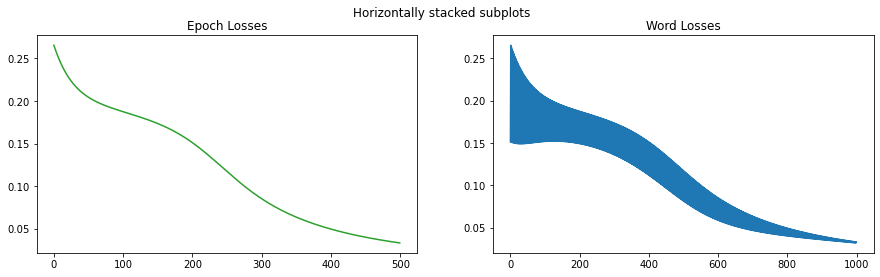

In [171]:
# Test training data: 
training_data = [ 
    ("The dog ate the apple".split(), torch.tensor([[1], [0], [0.5], [0.3], [1]])),
    ("Everybody read that book".split(), torch.tensor([[[0.2], [0], [1], [0]]]))
]
enc = Encoder(training_data)
model = exec_trial(
    training_data, 
    loss_function='mse', 
    do_label_encode=False,
    actifun='sigmoid',
    epochs=500,
    enc=enc
)
      
# See what the scores are after training
with torch.no_grad():
    inputs = enc.sequence_words(training_data[0][0])
    pred1 = model(inputs.to(device)) 
    inputs = enc.sequence_words(training_data[1][0])
    pred2 = model(inputs.to(device))
          
#print(hash(str(pred1.cpu().detach().numpy())), hash(str(pred2.cpu().detach().numpy())))
assert hash(str(pred1.cpu().detach().numpy())) == 2423810420677829124#8299978301676431484
assert hash(str(pred2.cpu().detach().numpy())) == -5139078890918265923#4865758014180741225

print('Unit test successful! :)')

## 4. Training and Predicting the Sentiment Score ##

Let's split our data 97% traing and 3% test data...

In [428]:
import random 

def list_splitter(list_to_split, ratio):
    elements = len(list_to_split)
    middle = int(elements * ratio)
    return [list_to_split[:middle], list_to_split[middle:]]


clean_training_data = []

for i, comment in enumerate(clean_comments):
    clean_training_data.append(
        (comment, torch.tensor([[clean_sentiments[i]]]*len(comment)))
    )
    
random.Random(66642999).shuffle(clean_training_data)
    
train, test = list_splitter(clean_training_data, 0.97)

print('Train / Test split:', len(train),'/',len(test))

Train / Test split: 21589 / 668


Now we are ready to train it!

Epoch 0 loss = 0.17097156405234207
Epoch 1 loss = 0.12667513344851242
Epoch 2 loss = 0.11004589649262729
Epoch 3 loss = 0.10096859413810533
Epoch 4 loss = 0.09456457222689882
Epoch 5 loss = 0.08959809815333657
Epoch 6 loss = 0.08574163207367985
Epoch 7 loss = 0.08280538620721381
Epoch 8 loss = 0.0803401709601287
Epoch 9 loss = 0.0782847160848471
Trial done! 


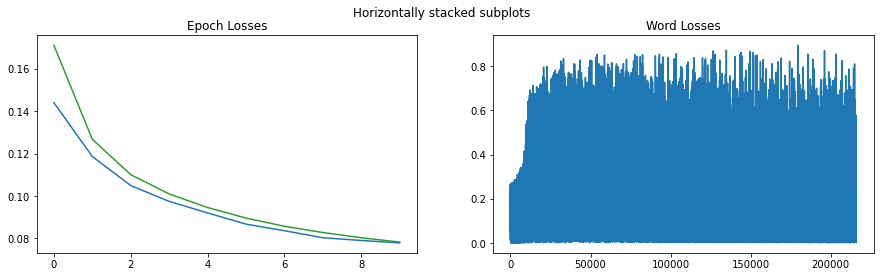

In [429]:
    
enc = Encoder(clean_training_data)
 
model = exec_trial(
    training_data=train, 
    test_data=test,
    loss_function='mse', 
    do_label_encode=False,
    actifun='sigmoid',
    epochs=10,
    enc=enc, 
    optimizer='adam',
    embedding_dim=32, # These is usually 32 or 64 dimensional.
    hidden_dim=128,# How large the lstm layer is...
    step_every_sentence=True 
)
#result = model.eval(test)
#print(result)


In [430]:
import time
date = str(time.time())
torch.save( model.state_dict(), 'models/FULL_final_lstm_model_state_dict_' + date ) 
torch.save( model,              'models/FULL_final_lstm_model_full_' + date ) 

# Model class must be defined somewhere
#model = torch.load(PATH)
#model.eval()

In [431]:
val_losses = []
loss_function = nn.MSELoss()

def evaluate_lstm(test_data):
    with torch.no_grad():
        for x_val, y_val in test_data: 
            model.eval() 
            sentence_in = enc.sequence_words(x_val).to(device)
            yhat = model(sentence_in)
            val_loss = loss_function(y_val.to(device), yhat)
            val_losses.append(val_loss.item())
            #if y_val.mean().item() < 0.5 or y_val.mean().item() > 0.999:
            pred = yhat.mean().item()
            real = y_val.mean().item()
            print(' '.join(x_val))
            print( "Predicted Sentiment: {0:.0%}".format(pred),"; Real Sentiment: {0:.0%}".format(real),';' )
            print('-=> ',pred,' should be ',real,'\n')
                
evaluate_lstm(test)

the kiffness - ievan polkka ft. bilal göregen (club remix) [official video] | bilal is he cannot see with both eyes since he's he's very to his pray happy
Predicted Sentiment: 96% ; Real Sentiment: 97% ;
-=>  0.9558150172233582  should be  0.9708902835845947 

bibi h - how it is ( wap bap ... ) [official video] | to dislikes laughing
Predicted Sentiment: 9% ; Real Sentiment: 7% ;
-=>  0.08934535831212997  should be  0.06785774976015091 

even the dislikes are more than for dislikes not for cool
Predicted Sentiment: 50% ; Real Sentiment: 4% ;
-=>  0.49633291363716125  should be  0.03825538977980614 

every programming tutorial | just write this here, don't worry i'll explain what this does never what it does
Predicted Sentiment: 93% ; Real Sentiment: 96% ;
-=>  0.9257639646530151  should be  0.9569754600524902 

i think you need another game of why come back your
Predicted Sentiment: 39% ; Real Sentiment: 95% ;
-=>  0.38731837272644043  should be  0.9485293030738831 

after earth offici

bibi h - how it is ( wap bap ... ) [official video] | ich den song jetzt ich
Predicted Sentiment: 8% ; Real Sentiment: 11% ;
-=>  0.08267538249492645  should be  0.10839829593896866 

why do i keep coming back to this
Predicted Sentiment: 53% ; Real Sentiment: 0% ;
-=>  0.5306261777877808  should be  0.0027469368651509285 

why you need to shift your focus | brooke houts | good people take care of their but even the of the are
Predicted Sentiment: 8% ; Real Sentiment: 0% ;
-=>  0.07934731990098953  should be  0.00255786650814116 

asmr ( lemongrass steamed cat) eating sounds. no talking | vi asmr | what you doing you doing a big stupid
Predicted Sentiment: 6% ; Real Sentiment: 0% ;
-=>  0.06272192299365997  should be  0.0015541304601356387 

trump shortens vacation, returns to white house |
Predicted Sentiment: 88% ; Real Sentiment: 99% ;
-=>  0.878703773021698  should be  0.992647111415863 

to the right of this video the first thing on is eating
Predicted Sentiment: 57% ; Real Sentim

magnets and marbles | the title have been magnets and !
Predicted Sentiment: 87% ; Real Sentiment: 100% ;
-=>  0.8660691380500793  should be  0.9970788359642029 

your head is like a bean from bean
Predicted Sentiment: 56% ; Real Sentiment: 0% ;
-=>  0.5581904053688049  should be  0.004660916049033403 

neujahrsansprache 2021 von bundeskanzlerin angela merkel | jetzt das nicht den
Predicted Sentiment: 80% ; Real Sentiment: 78% ;
-=>  0.8014524579048157  should be  0.7797479629516602 

sadak 2 | official trailer | sanjay | pooja | alia | aditya | jisshu | mahesh bhatt | 28 aug | imagine putting this shit on its me, time to up
Predicted Sentiment: 2% ; Real Sentiment: 0% ;
-=>  0.019242946058511734  should be  0.002563895657658577 

face book and twitter boy are u lying
Predicted Sentiment: 72% ; Real Sentiment: 98% ;
-=>  0.7213398218154907  should be  0.9767206907272339 

exploring shillong | shoot diaries | mr. faisu | kiss love you.
Predicted Sentiment: 6% ; Real Sentiment: 3% ;
-=> 

asmr* stewed dog's thighs. extremely delicious and nutritious(eating sounds) no talking | vi asmr | eat
Predicted Sentiment: 14% ; Real Sentiment: 5% ;
-=>  0.13696043193340302  should be  0.048494867980480194 

omg how on damn earth is this guy not
Predicted Sentiment: 67% ; Real Sentiment: 100% ;
-=>  0.6731360554695129  should be  0.9997463226318359 

i watched have watched this movie 10 times or more and i still love it but there may be some but it's why people disliked this movie because it became ... feels bad for all the people who in this movie tho :(
Predicted Sentiment: 54% ; Real Sentiment: 0% ;
-=>  0.5431680679321289  should be  0.0007962644449435174 

phd biologist destroys vegan activist! | lol. what the health as a this didn't age well.
Predicted Sentiment: 80% ; Real Sentiment: 78% ;
-=>  0.796602189540863  should be  0.7798957228660583 

dear people aren't disliking your videos because they don't like you to be honest i think you are great person but we all just want 

rebecca black - friday | when you're watching this on a
Predicted Sentiment: 7% ; Real Sentiment: 6% ;
-=>  0.07136280834674835  should be  0.05774259194731712 

in full: rowan atkinson on free speech | rowan is a
Predicted Sentiment: 92% ; Real Sentiment: 100% ;
-=>  0.9233031868934631  should be  0.9997106790542603 

hope everyone having a good and your hope she gets a
Predicted Sentiment: 65% ; Real Sentiment: 0% ;
-=>  0.6491546630859375  should be  0.0036093913950026035 

bhai hi video dislike ke ki video #1 trending ja hai ... love u bro ...
Predicted Sentiment: 30% ; Real Sentiment: 11% ;
-=>  0.303392231464386  should be  0.1065102219581604 

when this was no one at all able to see how this would or at the very how incredibly the
Predicted Sentiment: 48% ; Real Sentiment: 0% ;
-=>  0.4819454848766327  should be  0.0007962645031511784 

can we with the other if it makes no
Predicted Sentiment: 68% ; Real Sentiment: 100% ;
-=>  0.6846333742141724  should be  0.9999554753303528 



bibi h - how it is ( wap bap ... ) [official video] | einfach vor 1
Predicted Sentiment: 9% ; Real Sentiment: 5% ;
-=>  0.08816739916801453  should be  0.054344240576028824 

i can put and in my at a but not a ... ok wtf
Predicted Sentiment: 67% ; Real Sentiment: 97% ;
-=>  0.6731844544410706  should be  0.9693765044212341 

jake paul - it's everyday bro (song) feat. team 10 (official music video) | i like it when they talk because i'm
Predicted Sentiment: 5% ; Real Sentiment: 0% ;
-=>  0.047268111258745193  should be  0.002764200558885932 

where i've been | i like to think all her subscribers the so that they know when to dislike new videos thumbs up
Predicted Sentiment: 6% ; Real Sentiment: 0% ;
-=>  0.06357678025960922  should be  0.0008759367628954351 

jake paul - it's everyday bro (song) feat. team 10 (official music video) | this really a on my face
Predicted Sentiment: 5% ; Real Sentiment: 0% ;
-=>  0.05202803760766983  should be  0.0027538423892110586 

asmr ( lemongrass stea

why you need to shift your focus | brooke houts | you're so lost in it's getting
Predicted Sentiment: 11% ; Real Sentiment: 2% ;
-=>  0.10612291842699051  should be  0.01517616305500269 

i'm not dead | im but im and not and ... girl the thing on you is your
Predicted Sentiment: 14% ; Real Sentiment: 47% ;
-=>  0.14304085075855255  should be  0.4655563533306122 

youtube rewind 2018: everyone controls rewind | #youtuberewind | imagine watching this in
Predicted Sentiment: 78% ; Real Sentiment: 84% ;
-=>  0.7843635678291321  should be  0.8384059071540833 

i'm not apologizing | it's the not saying his name right but still crying about it for me
Predicted Sentiment: 13% ; Real Sentiment: 19% ;
-=>  0.13004645705223083  should be  0.19294320046901703 

bibi h - how it is ( wap bap ... ) [official video] | als noch soo viele
Predicted Sentiment: 8% ; Real Sentiment: 14% ;
-=>  0.0831976905465126  should be  0.13542532920837402 

thank you rowan i love your words and everyone will by it.
Pr

Now that we trained the model...<br>
Let's feed it some custom sentences and see what it predicts! :)

In [436]:

my_sentences = [ 
    # Negative
    ( 'eating a dog alive | i hate this bad video it is very bad'.split(), 0 ), 
    ( 'eating a cat alive | oh my god this could be my dear'.split(), 0 ), 
    ( 'i am not sorry | wow this guy has no heart'.split(), 0  ),
    # Positive
    ( 'january sales bean! | happy new year from india'.split(), 1 ),
    ( 'my cute cat lives in a parallel universe | great video much love every day'.split(), 1 ), 
]

my_sentences = list(
    map( 
        lambda s: (
            s[0], 
            torch.tensor( [[s[1]]]*len(s[0]), dtype=torch.float32, device=device) 
        ),
        my_sentences 
    )
)
  
print(evaluate_lstm(my_sentences))

eating a dog alive | i hate this bad video it is very bad
Predicted Sentiment: 15% ; Real Sentiment: 0% ;
-=>  0.14639368653297424  should be  0.0 

eating a cat alive | oh my god this could be my dear
Predicted Sentiment: 28% ; Real Sentiment: 0% ;
-=>  0.27927276492118835  should be  0.0 

i am not sorry | wow this guy has no heart
Predicted Sentiment: 31% ; Real Sentiment: 0% ;
-=>  0.3123944103717804  should be  0.0 

january sales bean! | happy new year from india
Predicted Sentiment: 78% ; Real Sentiment: 100% ;
-=>  0.7764683365821838  should be  1.0 

my cute cat lives in a parallel universe | great video much love every day
Predicted Sentiment: 88% ; Real Sentiment: 100% ;
-=>  0.876979649066925  should be  1.0 

None


 ---
 
 # Doing some good old Logistic Regression #
 
 
 ## 1. Bag of Words ##
 
 Although we already cleaned your data very thoroughly, for this approach we need
 to go even further! <br>
 We are going to use the `nltk` library in order to remove so called **"stopword"**, 
 which are very commen words that don not carry significant meaning...<br>
 ...and we are also going to convert the remaining words into their root form so that we reduce
 the noise in our data even more!<br>
 
In the English language, words can take multiple different forms depending upon where and how we use them. 
Lemmatizing is a process of bringing all different forms of a word to its root form so that machine looks at them as similar words.

For example- {‘keep’, ‘keeping’, ‘keeper’, ‘keeps’} will be reduced to a single word-‘keep’. 

In [437]:
import re
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
lemmatizer = nltk.stem.WordNetLemmatizer()

english_stop_words = nltk.corpus.stopwords.words('english')
print('Stop word in the english language:',len(english_stop_words))
print("'Let's take a look at a couple:\n")
print(' | '.join(english_stop_words[:25]),'...')


def keep_only_letters(word):
    word=re.sub(r'[^a-zA-Z\s]','',word)
    return word
 
def convert_to_lowercase(word):
    return word.lower()
 
def remove_stop_word(word):
    for stopword in english_stop_words:
        if word == stopword:
            return None
    return word

def lemmatize_word(word):
    #stemmer = nltk.porter.PorterStemmer()
    #stemmed = stemmer.stem(word)
    lemmared = lemmatizer.lemmatize(word)
    return lemmared
    
def clean_comment_further(text): 
    cleaned = []
    for word in text:
        word = keep_only_letters(word)
        word = convert_to_lowercase(word)
        word = remove_stop_word(word)
        if word != None and word != '' : 
            word = lemmatize_word(word)
            cleaned.append(word)
    return cleaned
 

Stop word in the english language: 179
'Let's take a look at a couple:

i | me | my | myself | we | our | ours | ourselves | you | you're | you've | you'll | you'd | your | yours | yourself | yourselves | he | him | his | himself | she | she's | her | hers ...


Now that we defined the methods for polishing the data, we now apply them and create carrier variables, namely:


- `train_X`, `train_Y` 
- `test_X`, `test_Y` 

Previously the training and test data we used for our neural networ
was a list of tuples which contained the X and Y values... <br>
Now we want to work with scikit-learn models so we have to convert these<br>
train test lists to these new variables: 

In [438]:
train_X, train_Y = [], []
test_X, test_Y = [], []

for x, y in train: 
    train_X.append(' '.join(clean_comment_further(x)))
    train_Y.append(y.mean().item())
    
for x, y in test:
    test_X.append(' '.join(clean_comment_further(x)))
    test_Y.append(y.mean().item())
  
print('Number of comments for training:',len(train_X))
print('Number of comments for testing:',len(test_X))

Number of comments for training: 21589
Number of comments for testing: 668


...hardly readable for us, but easy to encode for the computer! :)

## 2. Vectorization & Training ##

Now we use a vectorizer from the scikit-learn library to encode the text data...<br>
Then we binarize the sentiments and fit the `sklearn.linear_model.LogisticRegression()` model!

In [442]:

import sklearn
import sklearn.feature_extraction
import sklearn.linear_model

vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))

tf_features_train = vectorizer.fit_transform(train_X)
tf_features_test = vectorizer.transform(test_X)
print('Feature shapes of train / test arrays:',tf_features_train.shape,'/', tf_features_test.shape)

train_labels = [1 if sentiment > 0.85 else 0 for sentiment in train_Y]
test_labels = [1 if sentiment > 0.85 else 0 for sentiment in test_Y]
print('Number of train & test labels: ',len(train_labels),'/', len(test_labels))

clf = sklearn.linear_model.LogisticRegression()
clf.fit(tf_features_train, train_labels)
print ('Model used:',clf)

Feature shapes of train / test arrays: (21589, 1047) / (668, 1047)
Number of train & test labels:  21589 / 668
Model used: LogisticRegression()


C:\Users\Daglemino\Anaconda3\envs\dasi\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 3. Evaluation #

Finally we do some predictions and calculate informative metrics for them!

In [294]:
predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

              precision    recall  f1-score   support

    Negative       0.99      0.98      0.98       361
    Positive       0.97      0.99      0.98       254

    accuracy                           0.98       615
   macro avg       0.98      0.98      0.98       615
weighted avg       0.98      0.98      0.98       615

[[352   9]
 [  3 251]]


The accuracy is not bad, especially because of the fact that the amouont of data we used was rather small...<br>
Let's look at the binary predictions:

In [295]:
print(predictions)

[1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0
 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0
 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0
 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1
 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0
 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0
 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0
 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1
 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0
 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0
 0 0 0 0 1 1 0 0 1 1 1 1 

---

# Associating sentiments with words! #

The bag of words approach we tested previously leads us to another
strategy, based on the following question: <br>

- What if we calculate a fixed sentiment for every word?

Doing so would allow us to create a dictionary of words with an associated
sentiment. <br>
This dictionary could then be used to predict the sentiment of
whole sentences by simply calculating the average of the sentiments
of the words of a given sentence... <br>
Just like the previous approach this would ignore grammer as well
as the real meaning of a given sentence. <br>
However, for simple comments which contain words like "hate", "love", "good", "bad"... 
this approach might actually yield very good results!<br>

**Let's try it out!**

First we define a method which calculates a word-sentiment dictionary:

In [443]:

def train_word_sentiments(X, Y):
    word_sentiments = dict()
    for i, sentence in enumerate(X):
        words = sentence.split()
        sentiment = Y[i]
        for word in words:
            if word not in word_sentiments:
                word_sentiments[word] = (1, sentiment)
            else:
                count, accum_sent = word_sentiments[word]
                word_sentiments[word] = (count+1, accum_sent+sentiment)   
    final_word_sentiments = dict()
    for word, data in word_sentiments.items():
        count, accum_sent = data
        final_word_sentiments[word] = accum_sent / count
        
    return final_word_sentiments


Then we define a method which can do predictions based on such a dictionary:

In [444]:
def predict_sentence_by_words(word_sentiments, X, Y):
    pred = []
    for i, sentence in enumerate(X):
        words = sentence.split()
        sentiment = Y[i]
        sentiment_pred = 0
        count = 0
        for word in words:
            if word in word_sentiments:
                count += 1
                sentiment_pred += word_sentiments[word]
        
        if count>0 : pred.append(sentiment_pred/count)
        else : pred.append(0.5)
    return pred

And lastly, we train and test the concept with the previously 
created data, namely: <br>

- `train_X`, `train_Y` 
- `test_X`, `test_Y` 

In [445]:
    
word_sentiments = train_word_sentiments(train_X, train_Y)
predictions = predict_sentence_by_words(word_sentiments, test_X, test_Y)

loss = 0
for i, pred in enumerate(predictions):
    if test_Y[i]<0.5 or test_Y[i] > 0.9999:
        print(test_X[i],'\n-=> ',pred,' should be ',test_Y[i])
    loss += abs(pred-test_Y[i])
loss = loss / len(predictions)
print('====================================')
print('| Average loss:', loss)
print('====================================')

bibi h wap bap official video dislike laughing 
-=>  0.2061467925846565  should be  0.06785774976015091
even dislike dislike cool 
-=>  0.3086491827140424  should be  0.03825538977980614
youre fake youre even good 
-=>  0.4982337876756455  should be  0.029267994686961174
dislike video cant get trailer 
-=>  0.33231377054304334  should be  4.305713446228765e-05
come watching kgf teaser 
-=>  0.2775367742455397  should be  0.002587823197245598
khaali peeli teaser ishaan ananya panday maqbool khan coming soon worst laughing laughing worst worst 
-=>  0.16848657446492882  should be  0.004764243494719267
wrath jodi sound like couldnt take anymore 
-=>  0.6363567993985495  should be  0.9999646544456482
im sorry please sorry 
-=>  0.3188289242419864  should be  0.035381581634283066
im surprised didnt turn comment one 
-=>  0.48508205735438675  should be  5.632694956148043e-05
roomful teeth partita voice courante audio dark x x soundtrack dark heart 
-=>  0.9390902373162165  should be  0.99991

**This approach works surprisingly well!**

In [449]:
 
print("awesome:   {0:.0%}".format(word_sentiments['awesome']))
print("nice:      {0:.0%}".format(word_sentiments['nice']))
print("great:     {0:.0%}".format(word_sentiments['great']))
print("love:      {0:.0%}".format(word_sentiments['love']))
print("like:      {0:.0%}".format(word_sentiments['like']))
print("hate:      {0:.0%}".format(word_sentiments['hate']))
print("dislike:   {0:.0%}".format(word_sentiments['dislike']))
        


awesome:   66%
nice:      56%
great:     77%
love:      59%
like:      49%
hate:      39%
dislike:   14%


Most words have a pretty average score...<br>
Let's normalize it!

In [450]:
min_word_sentiment = 0.5
max_word_sentiment = 0.5

for word, sentiment in word_sentiments.items():
    if sentiment < min_word_sentiment: min_word_sentiment = sentiment
    if sentiment > max_word_sentiment: max_word_sentiment = sentiment
        
scaler = max_word_sentiment - min_word_sentiment

norm_word_sentiments = dict()
for word, sentiment in word_sentiments.items():
    norm_word_sentiments[word] = (sentiment - min_word_sentiment) / scaler
        

In [451]:
 
print("awesome:   {0:.0%}".format(word_sentiments['awesome']))
print("nice:      {0:.0%}".format(word_sentiments['nice']))
print("great:     {0:.0%}".format(word_sentiments['great']))
print("love:      {0:.0%}".format(word_sentiments['love']))
print("like:      {0:.0%}".format(word_sentiments['like']))
print("hate:      {0:.0%}".format(word_sentiments['hate']))
print("dislike:   {0:.0%}".format(word_sentiments['dislike']))
        

awesome:   66%
nice:      56%
great:     77%
love:      59%
like:      49%
hate:      39%
dislike:   14%


Nothing changed!